In [1]:
import csv
import datetime
import math
import random
import sys
import time

import shap
import seaborn as sns
import pandas as pd
import prince
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from optwrf.wrfparams import num2name
from optwrf.helper_functions import date2season

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

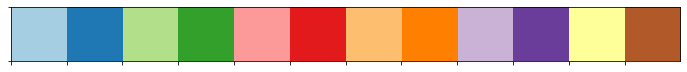

In [2]:
cmap1 = sns.color_palette('Paired', 12)
sns.palplot(cmap1)

In [2]:
def daylight(day, latitude=40):
    """
    This function calculates the number of daylight hours given jullian day of the year, and the latitude.
    For the optwrf work, I have set the default latitude to the 40th parallel since that cuts through
    the center of the domain. 
    """
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day - 186)))))
    pi = math.pi
    daylightamount = 24 - (24 / pi) * math.acos((math.sin(0.8333 * pi / 180) + 
                                                 math.sin(latitude * pi / 180) * math.sin(P)) 
                                                / (math.cos(latitude * pi / 180) * math.cos(P)))
    return daylightamount

In [3]:
# Read in the optwrf csv data file 
dateparse = lambda x: pd.datetime.strptime(x, '%b %d %Y')
data = pd.read_csv('./optwrf_database_050420.csv', parse_dates=['start_date'], date_parser=dateparse)
# Replace missing data with NaN values
data['fitness'].values[data['fitness'] > 6 * 10 ** 23] = np.nan
# Determine the season
data['season'] = [date2season(dat) for dat in data.start_date]
# Calculate the the normalized number of daylight hours
data['j_date'] = data.start_date.apply(lambda x: x.timetuple().tm_yday)
data['day_len'] = [daylight(data.j_date.iloc[N]) for N in range(len(data.j_date))]
data['day_len_frac'] = data['day_len']/max(data['day_len'])
# Calculate the corrected fitness based upon the day length
data['fitness_corrected'] = data.fitness/data.day_len_frac
data.iloc[:5,:]

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season,j_date,day_len,day_len_frac,fitness_corrected
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter,363,9.346323,0.622404,NaN
1,2011-11-27,13,5,7,5,5,14,1,2034.42319,4:39:34.359051,fall,331,9.660898,0.643353,3162.219899
2,2011-09-01,14,4,7,1,1,11,2,NaN,0:00:00.042498,fall,244,13.118862,0.873631,NaN
3,2011-04-06,18,1,5,7,9,16,1,NaN,6:00:01.733799,spring,96,12.838070,0.854932,NaN
4,2011-05-02,14,7,1,7,8,94,1,NaN,6:00:06.829933,spring,122,13.904221,0.925930,NaN


In [4]:
## Plots of each physics paramerization option vs. fitness

In [5]:
# Sort data by start_date to make the plots look cleaner
data = data.sort_values(by='start_date')
data

,start_date,mp_physics,ra_lw_physics,ra_sw_physics,sf_surface_physics,bl_pbl_physics,cu_physics,sf_sfclay_physics,fitness,runtime,season,j_date,day_len,day_len_frac,fitness_corrected
1047,2011-01-01,5,99,1,4,7,3,1,824.036064,02h 13m 02s,winter,1,9.375695,0.624360,1319.808860
37,2011-01-01,8,4,99,5,9,7,1,1432.446184,5:22:22.863760,winter,1,9.375695,0.624360,2294.262651
909,2011-01-01,51,4,1,1,5,2,1,1418.596397,00h 52m 03s,winter,1,9.375695,0.624360,2272.080282
467,2011-01-01,21,24,2,7,1,16,1,807.817349,01h 14m 11s,winter,1,9.375695,0.624360,1293.832321
203,2011-01-01,6,5,99,7,9,1,1,NaN,06h 00m 08s,winter,1,9.375695,0.624360,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2011-12-29,2,31,2,3,5,93,1,NaN,00:00:00,winter,363,9.346323,0.622404,NaN
433,2011-12-30,6,4,2,7,9,3,1,692.778015,01h 53m 35s,winter,364,9.353990,0.622915,1112.155377
5,2011-12-30,6,31,1,7,5,2,1,1363.634615,1:55:58.395966,winter,364,9.353990,0.622915,2189.119078
108,2011-12-30,2,4,24,5,9,94,1,890.534170,05h 09m 23s,winter,364,9.353990,0.622915,1429.624417


In [6]:
def format_plot(xlab='xlabel', ylab='ylabel'):
    # find and format dates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    date_fmt = mdates.DateFormatter('%b')

    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)

    # round to nearest month
    datemin = np.datetime64(data['start_date'].iloc[0], 'm')
    datemax = np.datetime64(data['start_date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    # format x and y labels
    plt.xlabel(xlab, fontsize=18)
    plt.ylabel(ylab, fontsize=18)

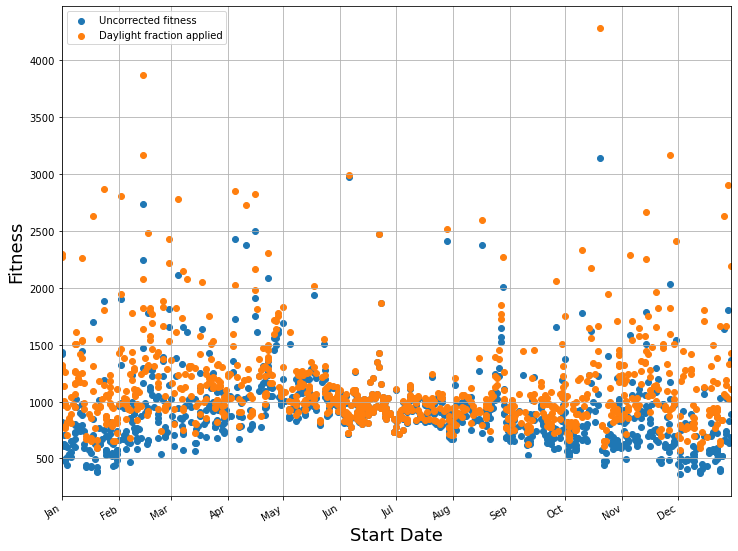

In [8]:
# Plot start_date vs fitness
start_date = data.start_date
fitness = data.fitness
f_daylight_normalized = data.fitness_corrected

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(start_date, fitness, label='Uncorrected fitness')
plt.scatter(start_date, f_daylight_normalized, label='Daylight fraction applied')
format_plot('Start Date', 'Fitness')
ax.legend()
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

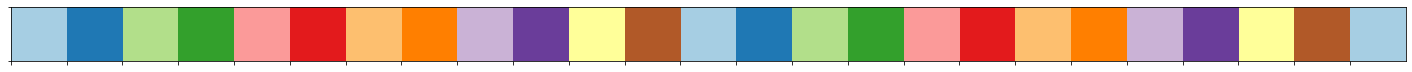

In [8]:
cmap1 = sns.color_palette('Paired', 25)
sns.palplot(cmap1)

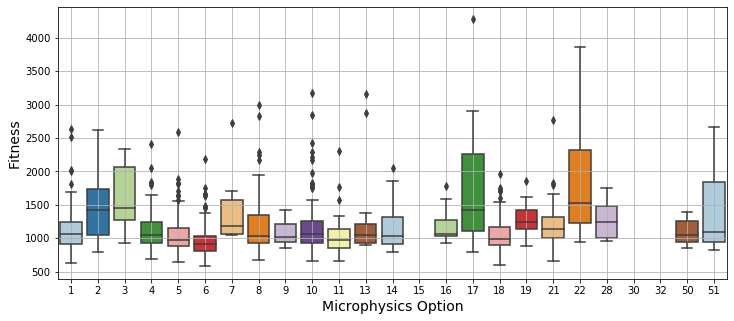

In [23]:
# Plot microphysics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='mp_physics', y='fitness', data=data, palette=cmap1)
# sns.boxplot(x='mp_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='mp_physics', y='fitness_corrected', data=data, palette=cmap1)

plt.xlabel('Microphysics Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvmp.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

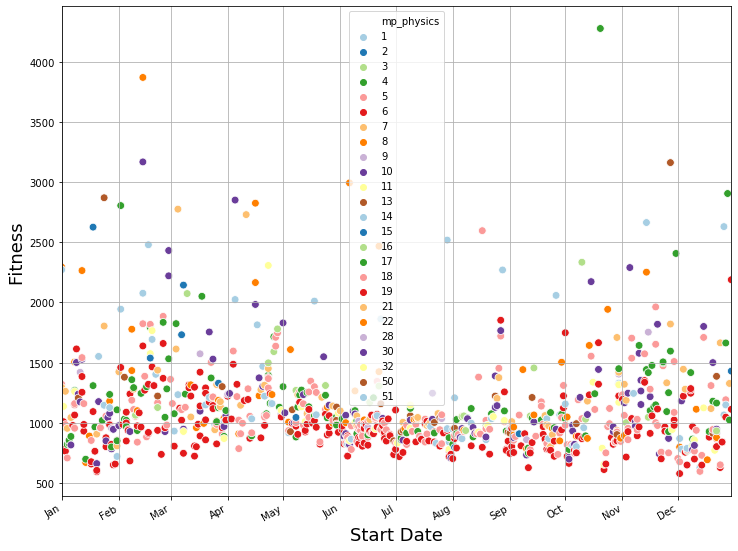

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.mp_physics, legend='full', palette=cmap1, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_mp.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

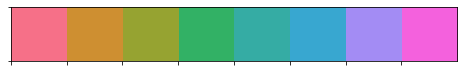

In [11]:
cmap2 = sns.husl_palette(8)
sns.palplot(cmap2)

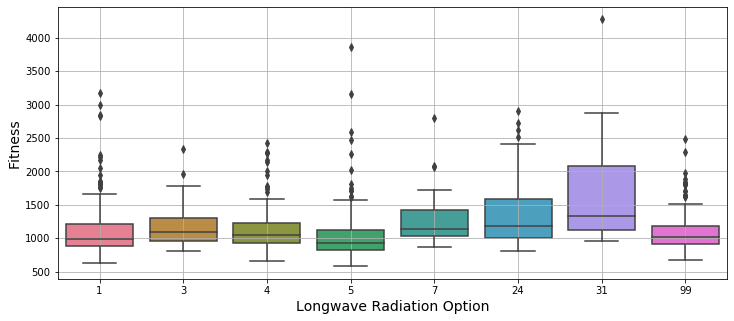

In [25]:
# Plot longwave radiation option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_lw_physics', y='fitness', data=data, palette=cmap2)
# sns.boxplot(x='ra_lw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_lw_physics', y='fitness_corrected', data=data, palette=cmap2)
plt.xlabel('Longwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

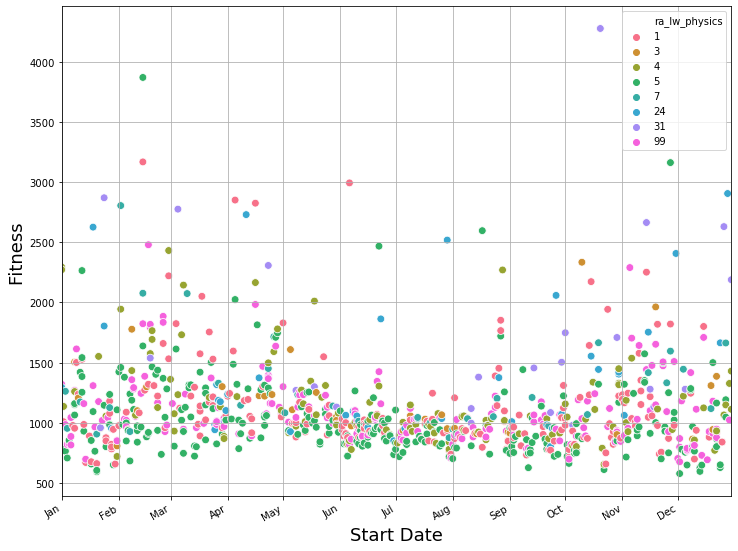

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.ra_lw_physics, legend="full", palette=cmap2, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_ralw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [14]:
# Paired; n = 8; desat = 0.60
cmap3 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

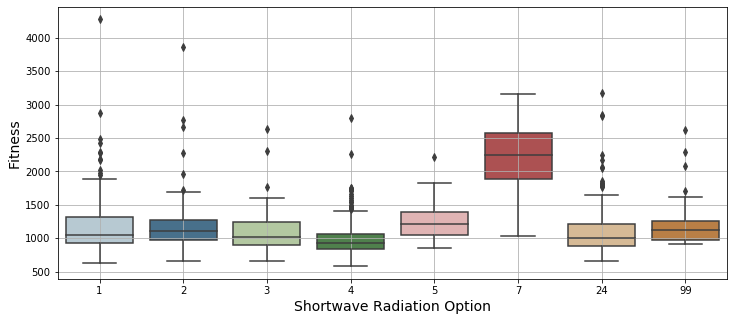

In [22]:
# Plot shortwave radiaiton option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='ra_sw_physics', y='fitness', data=data, palette=cmap3)
# sns.boxplot(x='ra_sw_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='ra_sw_physics', y='fitness_corrected', data=data, palette=cmap3)
plt.xlabel('Shortwave Radiation Option', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvrasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

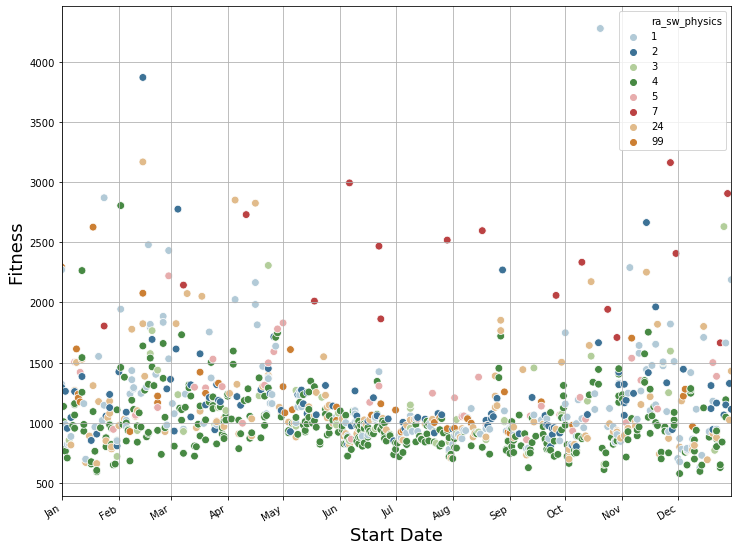

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.ra_sw_physics, legend="full", palette=cmap3, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_rasw.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [19]:
# Set2; n = 6; desat = 0.80
cmap4 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

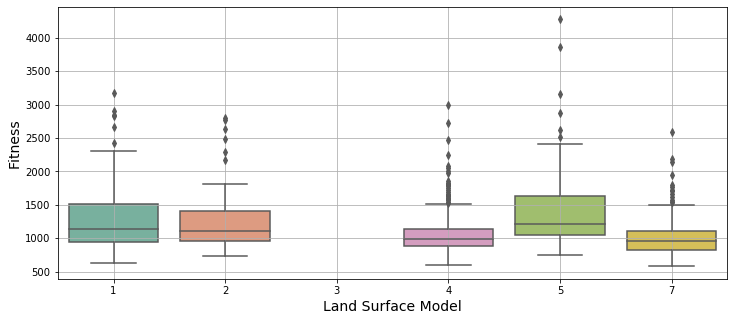

In [28]:
# Plot surface physics option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_surface_physics', y='fitness', data=data, palette=cmap4)
# sns.boxplot(x='sf_surface_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_surface_physics', y='fitness_corrected', data=data, palette=cmap4)
plt.xlabel('Land Surface Model', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvlsm.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

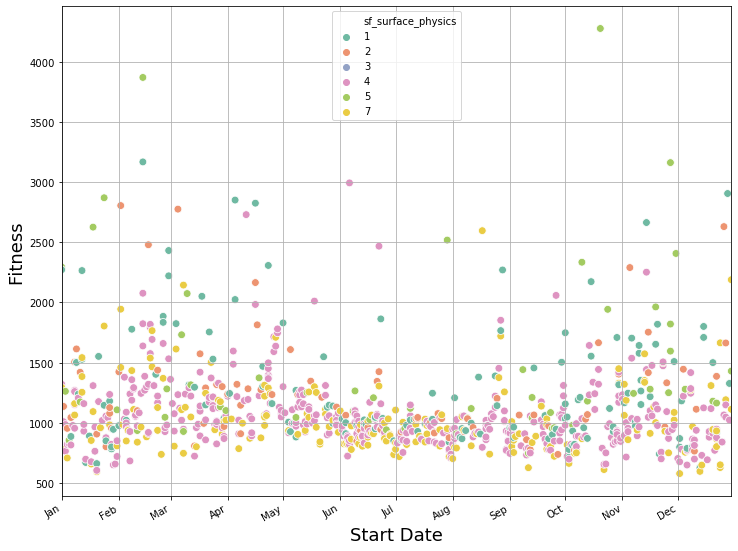

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.sf_surface_physics, legend="full", palette=cmap4, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_lsm.png'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [30]:
# Accent; n = 11; desat = 0.70
cmap5 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

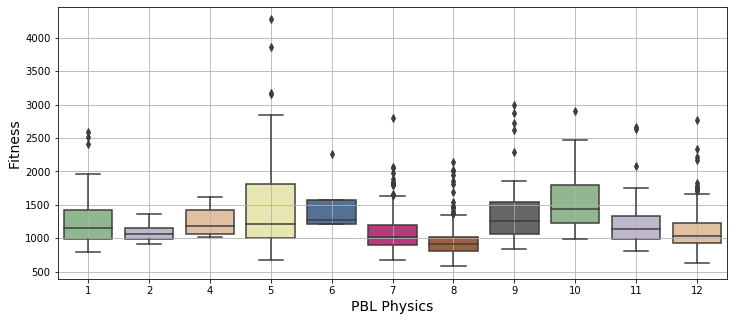

In [37]:
# Plot planetary boundary layer option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='bl_pbl_physics', y='fitness', data=data, palette=cmap5)
# sns.boxplot(x='bl_pbl_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='bl_pbl_physics', y='fitness_corrected', data=data, palette=cmap5)
plt.xlabel('PBL Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvpbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

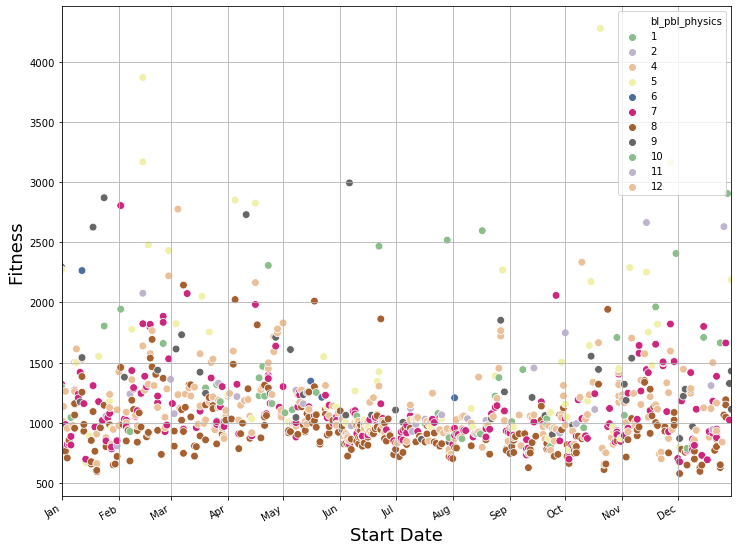

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.bl_pbl_physics, legend="full", palette=cmap5, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_pbl.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [33]:
# Dark2; n = 14; desat = 0.9
cmap6 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

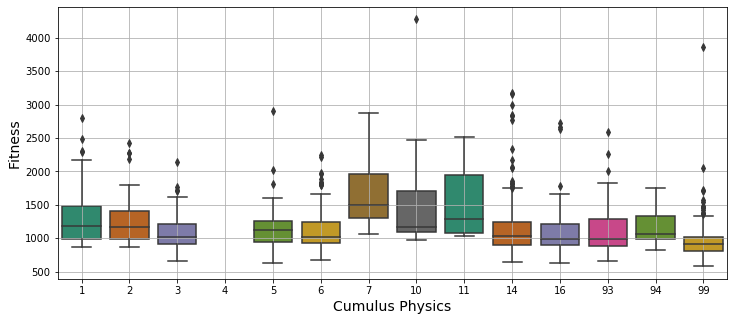

In [39]:
# Plot cumulus option vs. fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='cu_physics', y='fitness', data=data, palette=cmap6)
# sns.boxplot(x='cu_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='cu_physics', y='fitness_corrected', data=data, palette=cmap6)
plt.xlabel('Cumulus Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvcu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

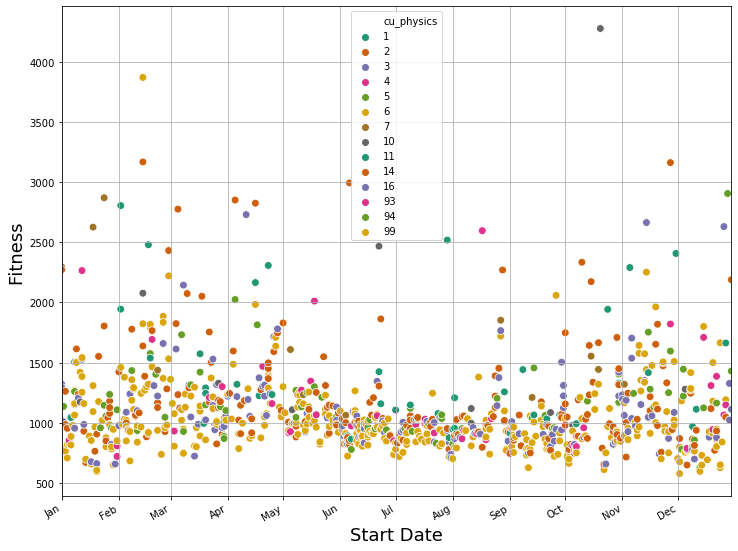

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.cu_physics, legend="full", palette=cmap6, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_cu.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

In [36]:
# Set1; n = 5; desat = 1.00
cmap7 = sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

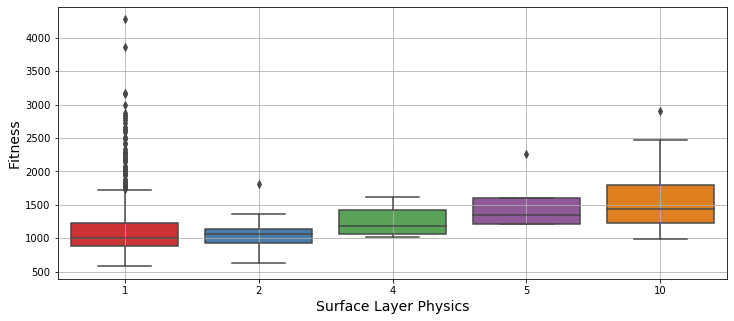

In [41]:
# Plot surface layer option vs. Fitness
fig, ax = plt.subplots(figsize=(12, 5))
# sns.catplot(x='sf_sfclay_physics', y='fitness', data=data, palette=cmap7)
# sns.boxplot(x='sf_sfclay_physics', y='fitness', data=data, palette='Greys')
sns.boxplot(x='sf_sfclay_physics', y='fitness_corrected', data=data, palette=cmap7)
plt.xlabel('Surface Layer Physics', fontsize=18)
plt.ylabel('Fitness', fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.grid(True)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Fitnessvsfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

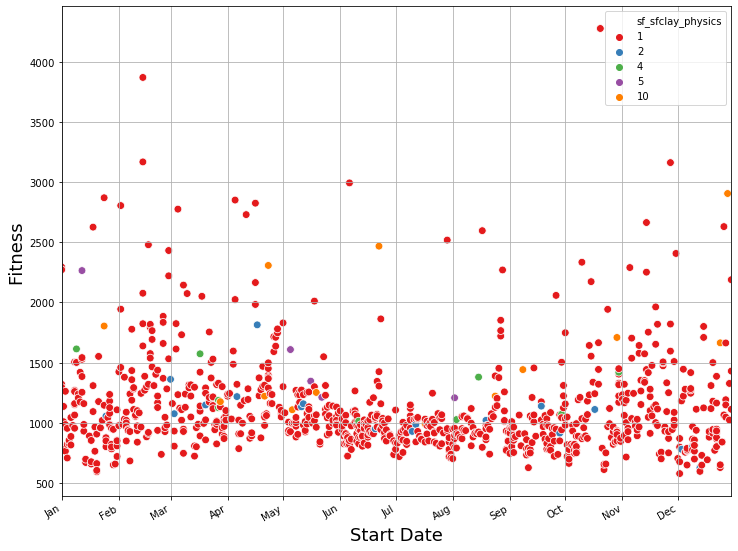

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(start_date, f_daylight_normalized, hue=data.sf_sfclay_physics, legend="full", palette=cmap7, s=60)
format_plot('Start Date', 'Fitness')
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/FitnessvStartDate_sfclay.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')

Text(0, 0.5, 'Fitness')

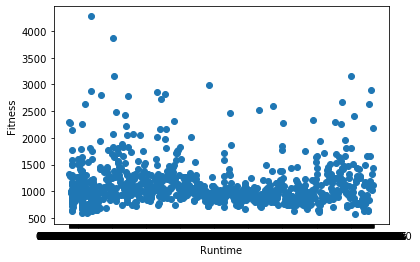

In [46]:
# Plot runtime vs fitness
data = data.sort_values(by='mp_physics')
runtime = data.runtime
fitness = data.fitness

fig, ax = plt.subplots()
plt.scatter(runtime, f_daylight_normalized)
plt.xlabel('Runtime')
plt.ylabel('Fitness')

In [47]:
## Heatmap showing the overall correlation matrix

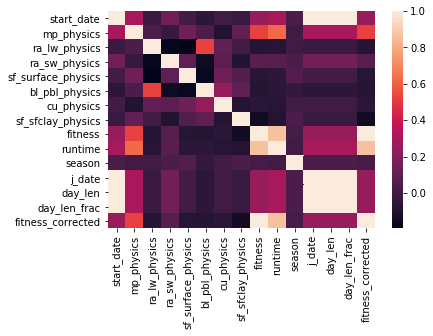

In [48]:
# Plot an overall heatmap
corr_matrix = data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_matrix)
fig_path = f'/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/Heatmap_overall.pdf'
plt.savefig(fig_path, transparent=True, bbox_inches='tight')